# Tarea N°1 | Procesamiento de lenguaje natural


<div>
<img src="https://i.ibb.co/v3CvVz9/udd-short.png" width="150"/>
    <br>
    <strong>Universidad del Desarrollo</strong><br>
    <em>Profesor: Maria Raveau</em><br>

</div>

*20 de julio de 2025*

**Nombre estudiante**: Camilo Rivera Verdugo  

-----------

## 1. Introducción

...

In [1]:
import pandas as pd
import numpy as np
import os
import nltk
from nltk.tokenize import word_tokenize
# import stanza
from nltk.tokenize import sent_tokenize
from nltk.stem import SnowballStemmer
import re

In [36]:
import stanza

/usr/local/lib/python3.10/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [7]:
cabildos = pd.read_excel('data/raw/resultadocabildoprovincial.xlsx', engine='openpyxl', header=0)

In [9]:
cabildos.shape

(30414, 12)

In [10]:
cabildos.head()

,region_nombre,provincia_nombre,comuna_nombre,cabildo_id,cabildo_nombre,cabildo_direccion,num_mesa,pregunta_glosa,concepto_nombre,concepto_otro,tipo-eleccion,fundamento
0,Arica y Parinacota,Arica,Arica,81,Colegio San Marcos,"Santa María 2140, Arica",1,¿Cuáles son los valores y principios más impor...,Autonomía/libertad,NaN,A,sin fundamento
1,Arica y Parinacota,Arica,Arica,81,Colegio San Marcos,"Santa María 2140, Arica",1,¿Cuáles son los valores y principios más impor...,Democracia,NaN,A,Sin fundamento
2,Arica y Parinacota,Arica,Arica,81,Colegio San Marcos,"Santa María 2140, Arica",1,¿Cuáles son los valores y principios más impor...,Descentralización,NaN,A,La descentralizacion de ser autonoma por ser z...
3,Arica y Parinacota,Arica,Arica,81,Colegio San Marcos,"Santa María 2140, Arica",1,¿Cuáles son los valores y principios más impor...,Equidad de género,NaN,A,Sin fundamento
4,Arica y Parinacota,Arica,Arica,81,Colegio San Marcos,"Santa María 2140, Arica",1,¿Cuáles son los valores y principios más impor...,Respeto/conservación de la naturaleza o medio ...,NaN,A,Sin fundamento


In [11]:
cabildos.columns

Index(['region_nombre', 'provincia_nombre', 'comuna_nombre', 'cabildo_id',
       'cabildo_nombre', 'cabildo_direccion', 'num_mesa', 'pregunta_glosa',
       'concepto_nombre', 'concepto_otro', 'tipo-eleccion', 'fundamento'],
      dtype='object')

In [30]:
cabildos.groupby('concepto_nombre').size().reset_index(name = "recuento").sort_values(by="recuento", ascending=False).head(30)

,concepto_nombre,recuento
82,Otro,7121
58,Igualdad,649
69,Justicia,619
9,A la salud,614
1,A la educación,611
41,Descentralización,610
100,Respeto/conservación de la naturaleza o medio ...,607
37,Democracia,604
86,"Plebiscitos, referendos y consultas",597
94,"Protección, promoción y respeto de los derecho...",582


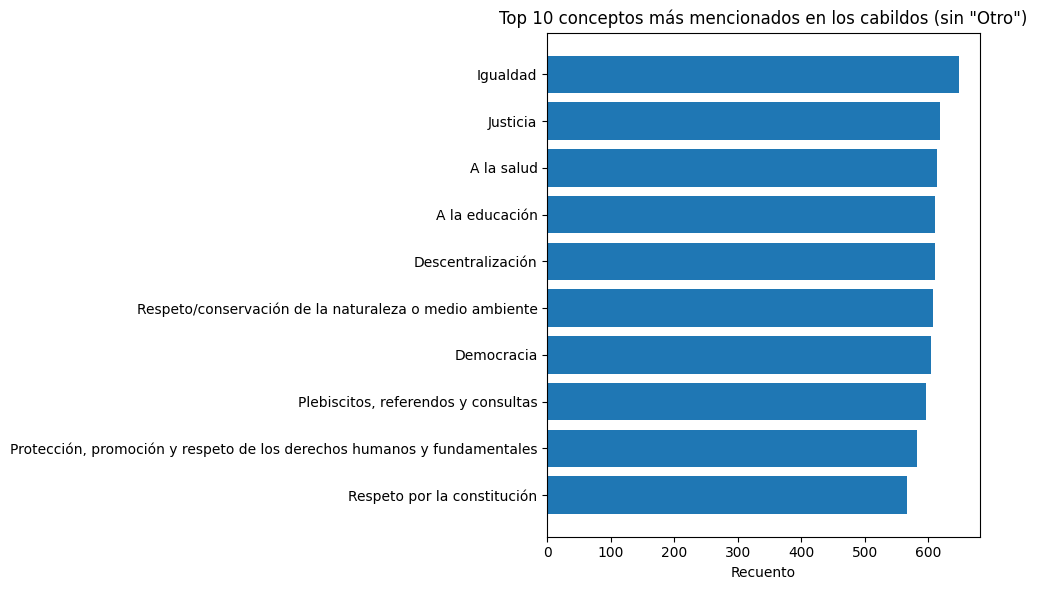

In [26]:
# Filtrar el DataFrame para excluir "Otro"
cabildos_filtrado = cabildos[cabildos['concepto_nombre'] != 'Otro']

import matplotlib.pyplot as plt

# Agrupar, contar y ordenar sin "Otro"
top_conceptos = cabildos_filtrado.groupby('concepto_nombre').size().reset_index(name='recuento')
top_conceptos = top_conceptos.sort_values(by='recuento', ascending=False).head(10)

# Crear gráfico de barras
plt.figure(figsize=(10, 6))
plt.barh(top_conceptos['concepto_nombre'][::-1], top_conceptos['recuento'][::-1])
plt.xlabel('Recuento')
plt.title('Top 10 conceptos más mencionados en los cabildos (sin "Otro")')
plt.tight_layout()
plt.show()


In [31]:
concepto = 'Descentralización'  # Ejemplo, puedes cambiarlo
df_concepto = cabildos[cabildos['concepto_nombre'] == concepto].copy()


In [33]:
df_concepto.head(10)

,region_nombre,provincia_nombre,comuna_nombre,cabildo_id,cabildo_nombre,cabildo_direccion,num_mesa,pregunta_glosa,concepto_nombre,concepto_otro,tipo-eleccion,fundamento
2,Arica y Parinacota,Arica,Arica,81,Colegio San Marcos,"Santa María 2140, Arica",1,¿Cuáles son los valores y principios más impor...,Descentralización,NaN,A,La descentralizacion de ser autonoma por ser z...
92,Arica y Parinacota,Arica,Arica,81,Colegio San Marcos,"Santa María 2140, Arica",4,¿Cuáles son los valores y principios más impor...,Descentralización,NaN,P,"18 integrantes estuvieron de acuerdo, 1 en des..."
143,Arica y Parinacota,Arica,Arica,81,Colegio San Marcos,"Santa María 2140, Arica",5,¿Cuáles son los valores y principios más impor...,Descentralización,NaN,A,Autonomia en la toma de decisiones a nivel com...
170,Arica y Parinacota,Arica,Arica,81,Colegio San Marcos,"Santa María 2140, Arica",6,¿Cuáles son los valores y principios más impor...,Descentralización,NaN,A,Sin fundamento
212,Arica y Parinacota,Arica,Arica,81,Colegio San Marcos,"Santa María 2140, Arica",7,¿Cuáles son los valores y principios más impor...,Descentralización,NaN,A,no tiene fundamentos
284,Arica y Parinacota,Arica,Arica,81,Colegio San Marcos,"Santa María 2140, Arica",9,¿Cuáles son los valores y principios más impor...,Descentralización,NaN,P,idem anterior
317,Arica y Parinacota,Arica,Arica,81,Colegio San Marcos,"Santa María 2140, Arica",10,¿Cuáles son los valores y principios más impor...,Descentralización,NaN,A,la realidad es que los servicios publicos esta...
364,Arica y Parinacota,Arica,Arica,81,Colegio San Marcos,"Santa María 2140, Arica",11,¿Cuáles son los valores y principios más impor...,Descentralización,NaN,A,la ciudadania necesita que las decisiones sean...
463,Arica y Parinacota,Arica,Arica,81,Colegio San Marcos,"Santa María 2140, Arica",13,¿Cuáles son los valores y principios más impor...,Descentralización,NaN,A,sin fundamento
492,Arica y Parinacota,Arica,Arica,81,Colegio San Marcos,"Santa María 2140, Arica",14,¿Cuáles son los valores y principios más impor...,Descentralización,NaN,A,Que la descentralización sea aplicado a la eco...


In [34]:
df_concepto = df_concepto[~df_concepto['fundamento'].str.lower().isin(['sin fundamento', 'idem anterior', 'no tiene fundamentos'])]


In [38]:
# Descargar recursos
stanza.download('es')
import nltk
nltk.download('punkt')
nltk.download('stopwords')

2025-07-16 20:22:54 INFO: Downloaded file to /root/stanza_resources/resources.json
2025-07-16 20:22:54 INFO: Downloading default packages for language: es (Spanish) ...
2025-07-16 20:22:56 INFO: File exists: /root/stanza_resources/es/default.zip
2025-07-16 20:23:00 INFO: Finished downloading models and saved to /root/stanza_resources
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [40]:
nlp = stanza.Pipeline(lang='es', processors='tokenize,mwt,pos,lemma,depparse')

2025-07-16 20:25:35 INFO: Checking for updates to resources.json in case models have been updated.  Note: this behavior can be turned off with download_method=None or download_method=DownloadMethod.REUSE_RESOURCES
2025-07-16 20:25:35 INFO: Downloaded file to /root/stanza_resources/resources.json
2025-07-16 20:25:36 INFO: Loading these models for language: es (Spanish):
| Processor | Package           |
---------------------------------
| tokenize  | combined          |
| mwt       | combined          |
| pos       | combined_charlm   |
| lemma     | combined_nocharlm |
| depparse  | combined_charlm   |

2025-07-16 20:25:36 INFO: Using device: cuda
2025-07-16 20:25:36 INFO: Loading: tokenize
2025-07-16 20:25:36 INFO: Loading: mwt
2025-07-16 20:25:36 INFO: Loading: pos
2025-07-16 20:25:39 INFO: Loading: lemma
2025-07-16 20:25:40 INFO: Loading: depparse
2025-07-16 20:25:41 INFO: Done loading processors!


In [41]:
def lemmatizer(text):  
    doc = nlp(text)
    lemas = []
    for sent in doc.sentences:
        lemas.extend([x.lemma for x in sent.words])
    return ' '.join(lemas)


In [44]:
def lemmatizer(text):  
    doc = nlp(text)
    return ' '.join([x.lemma for x in doc.sentences[0].words]) 


In [46]:
df_concepto['lemma'] = [lemmatizer(x) for x in df_concepto['fundamento']] 

### WordCloud de tokens/sustantivos

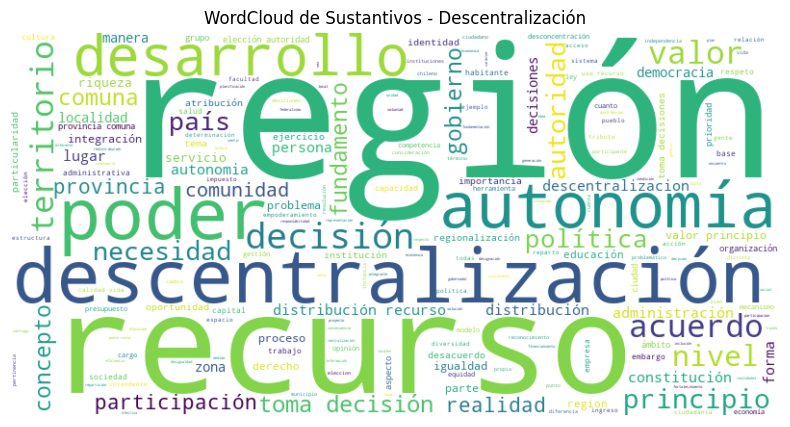

In [47]:
from nltk import word_tokenize
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import string

stopwords_esp = set(stopwords.words('spanish'))
signos = set(string.punctuation)

sustantivos = []

for texto in df_concepto['fundamento'].dropna():
    doc = nlp(texto)
    for sent in doc.sentences:
        for word in sent.words:
            if word.upos == 'NOUN':
                lemma = word.lemma.lower()
                if lemma not in stopwords_esp and lemma not in signos:
                    sustantivos.append(lemma)

# WordCloud de sustantivos
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(sustantivos))

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("WordCloud de Sustantivos - Descentralización")
plt.show()


### WordCloud de bigrama sustantivo–adjetivo

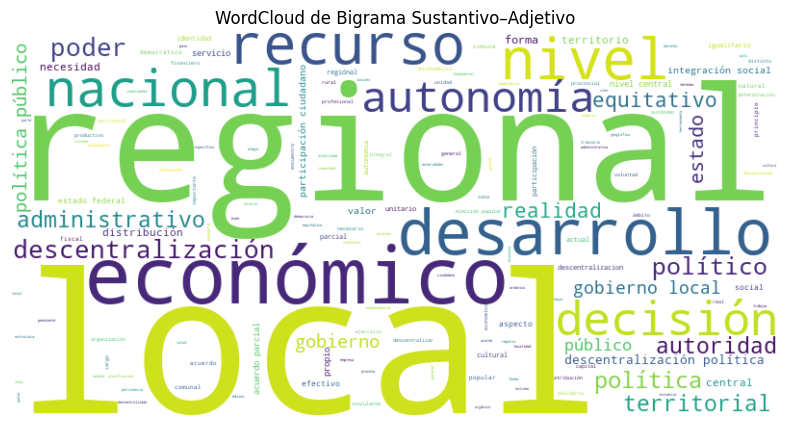

In [48]:
from nltk.util import bigrams
from collections import Counter

bigramas = []

for texto in df_concepto['fundamento'].dropna():
    doc = nlp(texto)
    for sent in doc.sentences:
        lemmas = [(w.lemma.lower(), w.upos) for w in sent.words]
        for i in range(len(lemmas) - 1):
            if lemmas[i][1] == 'NOUN' and lemmas[i + 1][1] == 'ADJ':
                bigrama = f"{lemmas[i][0]} {lemmas[i + 1][0]}"
                bigramas.append(bigrama)

# WordCloud de bigramas sustantivo-adjetivo
wordcloud_bigrams = WordCloud(width=800, height=400, background_color='white').generate(' '.join(bigramas))

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_bigrams, interpolation='bilinear')
plt.axis('off')
plt.title("WordCloud de Bigrama Sustantivo–Adjetivo")
plt.show()


### Red de bigramas sustantivo–adjetivo

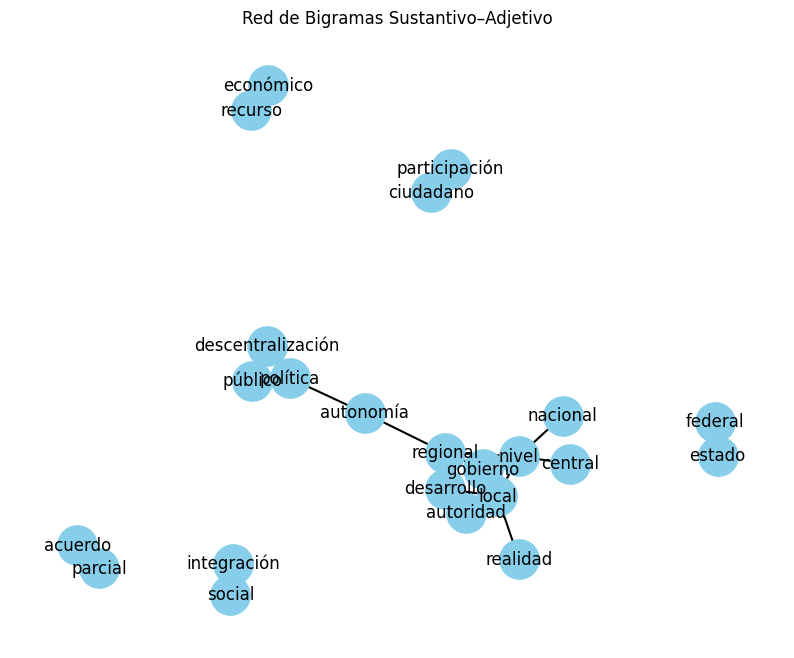

In [54]:
import networkx as nx

# Contar los bigramas más frecuentes
conteo_bigramas = Counter(bigramas).most_common(20)

# Crear red
G = nx.Graph()
for par, freq in conteo_bigramas:
    n1, n2 = par.split()
    G.add_edge(n1, n2, weight=freq)

# Dibujar red
plt.figure(figsize=(10, 8))
pos = nx.spring_layout(G, k=0.5)
nx.draw_networkx_nodes(G, pos, node_color='skyblue', node_size=800)
nx.draw_networkx_edges(G, pos, width=1.5)
nx.draw_networkx_labels(G, pos, font_size=12)
plt.title("Red de Bigramas Sustantivo–Adjetivo")
plt.axis('off')
plt.show()


### Frases de ejemplo para describir el concepto

In [55]:
df_concepto['fundamento'].dropna().sample(5, random_state=42).tolist()


['Acuerdo.',
 'Autoridades elegidas por votación popular  y que se contemple mecanismos de participación ciudadana.',
 'Chile es un país muy diverso por su geografía, debido a que la región de Magallanes es un territorio aislado con 60% de ASP es que se requiere de un poder mas amplio para planificar e implementar un desarrollo sostenible del territorio con énfasis en la consideración de la naturaleza.',
 'Las Regiones deben tener más facultades para la autogestión.',
 'AUTONOMÍA, DECISIÓN ACORDE AL TERRITORIO']

In [56]:
df_concepto[df_concepto['fundamento'].str.contains("autonomía", case=False, na=False)].sample(3)['fundamento'].tolist()


['Autonomía de las regiones y/o comunidades para tomar decisiones que les afecten. Más participación de localidades /comunidades  que son las que mejor conocen lo que tienen. Atención a realidades diversas, en diferentes ámbitos (Salud, educación, alimentación, entre otras)',
 'Asegurar un nivel de autonomía que radique en una esfera relevante de decisiones política en la región. Atribuir poder de decisión en el marco de las políticas del Estado, a los territorios en que se divide la organización político administrativa en la región',
 'permite dar las atribuciones necesarias a los territorios y sus autoridades para definir los procesos de desarrollo con autonomía.']